# Laboratoire 6
## Filtre de Kalman Étendu (EKF)

### Partie 1 - Calibration du capteur

In [2]:
# Importation des modules
%load_ext autoreload
%autoreload 2
%matplotlib inline

import math
import time

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from matplotlib import gridspec

from robmob.robot import Robot
from robmob.rover.sensors import LDLidarSensor, RobotEspSensor
from robmob.rover.commands import MovementFloatCommand, ResetCommand

Modifiez la valeur de `ip_robot` selon le robot qui vous a été assigné.

In [3]:
# Connexion au robot
ip_robot = 'localhost'
robot = Robot(ip_robot)
robot.connect()

In [4]:
lidar = LDLidarSensor()
robot.add_sensor(lidar)

Utilisez cette cellule pour vérifier que votre LiDAR est bien branché et retourne des données.
Dans le cas où la cellule suivante retourne `(0,)`, assurez-vous que le LiDAR est branché.

In [5]:
data = lidar.read_buffer()
print(data.shape)

(8,)


### Mesure de distance avec le LiDAR

Comme capteur, vous utiliserez le capteur LiDAR sur le dessus de la plateforme robotique.
Afin de ne retourner que la distance vers l'avant du véhicule, utilisez les fonctions suivantes.

In [6]:
def lidar_to_3d_homogeneous_matrix(lidar_data, cone_angle_degrees=10):
    ranges = np.array(lidar_data['ranges'])
    thetas = np.arange(lidar_data['angle_min'], lidar_data['angle_max']+lidar_data['angle_increment'], lidar_data['angle_increment'])[:len(ranges)]
    xs = ranges * np.cos(thetas)
    ys = ranges * np.sin(thetas)
    
    pts = np.vstack((xs, ys, np.zeros(xs.shape), np.ones(xs.shape))).T

    # Keep points in front
    delta = np.deg2rad(cone_angle_degrees)
    mask_min = thetas > np.pi / 2 -  delta / 2
    mask_max = thetas < np.pi / 2 + delta / 2
    mask = np.bitwise_and(mask_min, mask_max)
    
    pts = pts[mask]
    ranges = ranges[mask]
    
    # Remove the points that are at the origin.
    nz = np.nonzero(np.logical_or(pts[:,0] != 0., pts[:,1] != 0.))
    pts = pts[nz]
    ranges = ranges[nz]
    
    return pts, ranges

In [7]:
pointcloud, ranges = lidar_to_3d_homogeneous_matrix(lidar.peek_data())

In [8]:
def plot_point_clouds(pcls):
    STYLES = ['r+', 'bx', 'g*', 'md', 'ys']
    
    for i, pcl in enumerate(pcls):
        plt.plot(pcl[:,0], pcl[:,1], STYLES[i], label='Nuage {}'.format(i))
        plt.plot([0.0], [0.0], 'ko')
        
    plt.axis('equal')
    plt.legend()
    plt.show()

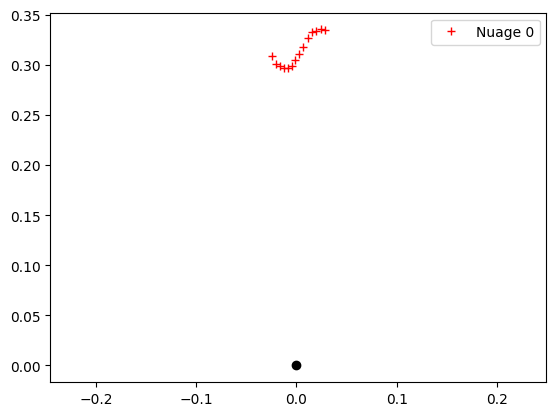

In [9]:
plot_point_clouds([pointcloud])

In [10]:
def estimate_distance(lidar_data, cone_angle_degrees=10):
    pc, ranges = lidar_to_3d_homogeneous_matrix(lidar_data)
    return np.mean(ranges)

In [11]:
estimate_distance(lidar.peek_data())

0.3137857

### Fonction de capteur

Afin de rendre le problème un peu plus intéressant, nous allons simuler un capteur de distance similaire au Sharp utilisé lors du laboratoire 1.

Voici la fonction simulé

In [17]:
def f_sensor(distance, k1=3, k2=1, noise=0):
    z = k1 + k2/(distance*100) # convert to cm with *100
    if isinstance(distance, np.ndarray):
        z += np.random.randn(*distance.shape) * noise
    else:
        z += np.random.randn() * noise
    return z

Text(0, 0.5, 'Measure (V)')

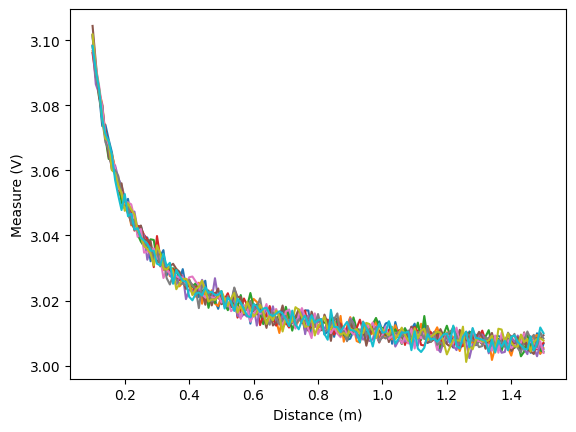

In [20]:
x = np.linspace(10, 150, 141)/100 # convert to meters with /100
for _ in range(10):
    plt.plot(x, f_sensor(x, noise=0.002))
plt.xlabel('Distance (m)')
plt.ylabel('Measure (V)')

#### Collecte de données
Prenez une série de mesures séparées de 5 cm, entre 30 cm et 120 cm. Prenez note que le buffer prend environ 2 secondes à ce remplir, donc prenez votre temps entre les mesures.
Soyez attentifs, car ces mesures
serviront à calibrer votre capteur infrarouge et aussi à tester votre filtre de Kalman.

Dans la cellule suivante, utilisez ```t``` (take) pour prendre la mesure et ```r``` (retry) pour reprendre la mesure. 

In [62]:
xs = np.array([x for x in range(30, 125, 5)]) * 0.01  # Distances à calibrer en mètres
zs = []
range_measures = []

In [63]:
# Capture des données de calibration
sigma_sensor = 0.002
k1 = 3
k2 = 1

for x in xs:
    key_in = ''
    while key_in != 't':
        distance = estimate_distance(lidar.peek_data())
        z = f_sensor(distance, k1=k1, k2=k2 noise=sigma_sensor)
        print("mesure pour x = %f" % x)
        print("moyenne des mesures: %f" % z)
        print("moyenne des distance: %f" % distance)
        print("(t)ake / (r)etry")
        key_in = input()
    zs.append(z)
    range_measures.append(distance)
    clear_output()
    time.sleep(0.5)

zs = np.asarray(zs)

print(xs.shape, zs.shape)

mesure pour x = 0.400000
moyenne des mesures: 1.457500
(t)ake / (r)etry


KeyboardInterrupt: Interrupted by user

### Partie 2 - Modèle du système

Normalement il faudrait estimer le bruit sur le capteur infrarouge, dans le cas du Sharp la valeur de $\sigma^2_{infrarouge} = (0.02V)^2$, ce qui correspond approximativement à un palier du convertisseur analogique-numérique. Dans notre cas, nous simulons un Sharp avec le LiDAR, il est donc possible d'utiliser la valeur du bruit directement. Le bruit de
déplacement sera $\sigma^2_{pas} = (0.002 m)^2$, ce qui donne essentiellement un écart-type de 2 mm sur un pas du
robot. Fait à noter, le choix de ces valeurs influencera grandement le comportement du filtre. Ainsi, si
vous choisissez un estimé de bruit de capteur $\sigma^2_{infrarouge}$
plus petit, vous indiquez au filtre qu’il doit
augmenter sa confiance envers les mesures du capteur. De la même manière, si vous diminuez la valeur
estimée du bruit sur les commandes $\sigma^2_{pas}$, il augmentera sa confiance envers l’estimé $x(k+1\,|\,k)$ obtenu lors
de la phase de prédiction. Nous y reviendrons lors des manipulations.

> **NOTE** Le bruit associé à la conversion analogique-numérique est généralement modélisé comme une distribution uniforme entre
±un demi-palier de conversion. Pour les curieux, une discussion complète de ce sujet est disponible sur wikipedia :
http://en.wikipedia.org/wiki/Quantization_error

La dynamique du système et la commande sont linéaires pour ce système:

$$
x(k + 1\,|\,k) = x(k) + u(k)
$$

Ce qui nous donne les matrices ```F``` (ou $\Phi$ sur les acétates) $= [1]$ et ```G``` (ou $\Gamma$ sur les acétates) $= [1]$. La fonction de mesure, telle qu'exprimée précédemment, est quant à elle non-linéaire:

$$
f_{infrarouge}(x) = K_{1 Sensor} + \frac{K_{2 Sensor}}{x}, x > 30
$$

Pour l’utiliser dans un filtre de Kalman, nous allons donc devoir linéariser cette fonction autour du point
d’opération $x$ (la position estimée du robot). La jacobienne ```H``` (ou $\Lambda$ sur les acétates) est utilisé par le
filtre de Kalman étendu (EKF) pour effectuer cette linéarisation :

$$
H = \Big[\frac{\delta}{\delta x} f_{infrarouge}(x)\Big] = \Big[ \frac{-K_{2Sensor}}{x^2}\Big]
$$

Cette matrice ```H``` (ou $\Lambda$ sur les acétates) est de taille $n\times m$, où $n$ est le nombre de capteurs et $m$ la longueur
du vecteur d’état. Pour ce système, sa taille est de 1x1, car nous avons une variable d’état (la position),
et un seul capteur (infrarouge Sharp). 

> **IMPORTANT!** La valeur numérique de ```H``` est recalculée à chaque
itération par le filtre EKF, car la pente de la fonction du capteur dépend de la position $x$. Aussi, le filtre
utilise l’estimé ```X``` pour la calculer, car nous ne connaissons pas la vraie valeur de $x$. C’est d’ailleurs une
des sources d’échec du filtre : si ```X``` et $x$ sont très différents, alors la valeur de ```H``` sera incorrecte, et le filtre
risque de diverger. Plus la fonction sera non-linéaire, et plus la distance |```X```-$x$| posera problème.

### Partie 3 - Collecte de données

<p style="background: yellow">Linker le notebook de commande (maybe updater le notebook)<hl>
<p style="background: yellow">Afficher les données<hl>

Il est possible d’utiliser un filtre de manière offline, c’est-à-dire après que les données soient toutes
capturées par le robot. Ceci a l’avantage de faciliter votre familiarisation avec ce filtre.

Dans cette partie, nous allons collecter des données que nous allons ensuite utiliser dans la partie suivante sur le filtre de Kalman.

Placez votre robot à la position de départ 0.30 m. Le script suivant fait reculer le robot à coups de 0.05m en enregistrant à chaque fois la mesure de l'infrarouge. **Si vous utilisez le simulateur**, utilisez l'oracle afin de mesurer la distance entre le robot et le mur.**IMPORTANT: Laissez de l'espace à l'arrière du robot pourqu'il puisse reculer ~1m.** **Une fois positionné, fermez le terminal avec le teleop.**

In [ ]:
# Affiche la distance mesurée par l'oracle
print(oracle_sensor.read_buffer())

In [ ]:
simulator = SimulatorSensor()
robot.add_sensor(simulator)
time.sleep(1)

In [ ]:
delta_t = 1  # intervalle des mesures en sec
speed = 0.05  # m/s

x_0 = 0.3
x_final = 1.20
distance = (x_final - x_0)
n_steps = math.ceil(distance / abs(speed) / delta_t)
step_distance = delta_t * abs(speed)

positions = np.zeros((n_steps,))
measures = np.zeros((n_steps,))

for i in range(n_steps):
    positions[i] = x_0 + i * step_distance
    measures[i] = sharp_sensor.peek_data()

    robot.linear_movement_precise(step_distance, speed)
    time.sleep(0.6)  #Laisser le temps au buffer de se remplir

print(np.vstack((positions, measures)))

Si vous êtes satisfait des données collectées, utilisez la cellule suivante pour les enregistrer

In [ ]:
data_to_save = np.vstack((positions, measures))
np.savetxt("./lab6_offline_data.txt", data_to_save)

### Partie 4 - Filtre

Assurez-vous de bien comprendre l'implémentation du filtre de Kalman.

In [ ]:
# Load data
positions, measures = np.loadtxt("./lab6_offline_data.txt")

In [ ]:
delta_t = 1  # intervalle des mesures en sec
n_steps = positions.shape[0]
speed = 0.05  # m/s
sigma_rover = 0.0025  # (m) ecart-type sur un pas du robot rover

Cv = sigma_rover ** 2
Cw = sigma_sensor ** 2

# Actions du système
u = 0.05

# Calibration - doit avoir été faites plus haut
assert (k_1 is not None and k_2 is not None)

X = positions[0]  # On connait exactement la position initiale du robot
P = 0.00 ** 2

#Données à recueillir pour tracer les graphiques
graph_data = {
    "x": [positions[0]],
    "x_estimate": [X],
    "z": [measures[0]],
    "K": [0],
    "P": [P],
    "error": [positions[0] - X],
    "time": [0]
}

for i in range(1, n_steps):  # On commence le compteur à 1, car 0 est l'état initial à 30cm, et 1 est après
    # la première commande
    time = i * delta_t

    z = measures[i]

    F = np.array([1])  # Phi, pour dynamique systeme
    G = np.array([1])  # Gamma, pour matrice de commande

    # Propagation de l'estimé
    X = F * X + G * u
    P = F * P * F.T + G * Cv * G.T  # Propagation covariance

    # ========= Calcul des matrices Jacobiennes pour mise-a-jour =============
    H = -k_2_sharp / X ** 2  # Je dois utiliser mon estimé pour ici, car je ne connais pas la vraie valeur

    z_hat = k_1_sharp + k_2_sharp / X;

    # ======== Mise-a-jour ========
    K = P * H.T / (H * P * H.T + Cw)  # Gain Kalman
    r = (z - z_hat)  # Innovation
    X = X + K * r
    P = (1 - K * H) * P

    # Cueillette des données pour le graphique
    graph_data["x"].append(positions[i])
    graph_data["x_estimate"].append(X)
    graph_data["z"].append(z)
    graph_data["K"].append(K)
    graph_data["P"].append(P)
    graph_data["error"].append(positions[i] - X)
    graph_data["time"].append(time)



### Partie 5 - Visualisation des résultats

In [ ]:
fig = plt.figure(figsize=(6, 12))
gs = gridspec.GridSpec(3, 1)

ax1 = plt.subplot(gs[0])
ax1.set_title("Position (commandes)")
ax1.plot(graph_data['time'], graph_data['x'], '-o', label="Commandes")
ax1.grid(True)

ax2 = plt.subplot(gs[1])
ax2.set_title("Estimé de position (filtre)")
ax2.plot(graph_data['time'], graph_data['x_estimate'], '-o', label="Estimé Filtre")
ax2.set_ylabel('position (m)')
ax2.grid(True)

# On inverse la fonction de capteur pour trouver la position estimée
# par le capteur infrarouge
z_numpy = np.array(graph_data['z'])
x_sharp_estimated = k_2_sharp / (z_numpy - k_1_sharp)
ax3 = plt.subplot(gs[2])
ax3.set_title("Estimé de position (sharp)")
ax3.plot(graph_data['time'], x_sharp_estimated, '-o', label="Estimé Sharp")
ax3.set_xlabel("temps (s)")
ax3.grid(True)

plt.show()

In [ ]:
plt.title("Position et estimées")
plt.xlabel("temps (s)")
plt.ylabel("position (m)")
plt.plot(graph_data['time'], graph_data['x'], label="Commandes")
plt.scatter(graph_data['time'], graph_data['x_estimate'], marker='x', label="Estimé Filtre")
plt.scatter(graph_data['time'], x_sharp_estimated, marker='o', color='red', label="Estimé Sharp")
plt.legend(loc='upper left')

In [ ]:
plt.title("Erreur en fonction du temps")
plt.xlabel("temps (s)")
plt.ylabel("erreur (m)")
plt.scatter(graph_data['time'], graph_data['error'])

In [ ]:
cov = np.array(graph_data['P']) * 1000000
plt.title("Covariance en fonction du temps")
plt.xlabel("temps (s)")
plt.ylabel("Covariance ((mm)^2)")
plt.scatter(graph_data['time'], cov)

In [ ]:
plt.title("Gain de Kalman en fonction du temps")
plt.xlabel("temps (s)")
plt.ylabel("Gain")
plt.scatter(graph_data['time'], graph_data['K'])

In [ ]:
sharp_errors = graph_data['x'] - x_sharp_estimated
plt.title("Écart-type infrarouge=%.3f mm" % np.std(sharp_errors * 1000))
plt.hist(sharp_errors, bins=12)
plt.show()

In [ ]:
errors = [float(e) for e in np.asarray(graph_data['error'])]
plt.title("Écart-type filtre Kalman=%.3f mm" % np.std(errors * 1000))
plt.hist(errors[1:], bins=10)
plt.show()

#### Discussion

**ATTENTION:** Il faut s'assurer de bien comprendre le code et de bien développer l'intuition pour le filtre. Modifiez les différents paramètres pour voir comment le filtre se comporte.

**Question:** Quel comportement voyez-vous? En particulier, vous devriez observer que 

- la précision sur la position estimée diminue au fil du temps, ce qui reflète l’accumulation progressive des erreurs;

- la matrice de covariance P reflète bien cette situation, en accroissant avec le temps;
- la valeur absolue 2 du gain K du filtre augmente au début, car le filtre doit tenir compte de plus en plus de la mesure pour corriger l’estimé de la position à mesure que notre estimé perd de la précision.


Normalement, la valeur de la covariance P et du gain K se stabilise, ce qui n’est pas le cas en ce
moment. Pourquoi? Eh bien à mesure que vous vous éloignez, votre capteur perd énormément de
précision, et la matrice P et le gain K doivent refléter cette situation. Pour un scénario plus réaliste, le
robot resterait toujours dans les mêmes parages, et P et K convergeraient vers une valeur fixe. Rappelez-
vous que pour ce système :

$$
K = \frac{PH^T}{HPH^T + \sigma^2_{infrarouge}}
$$


> **NOTE** Pour ce système, le gain K est négatif. La courbe montera donc une valeur descendante pour une augmentation de la valeur absolue du gain.



### Partie 6 - Trajet inverse
Répétez l'expérience précédente mais en faisant comme si le robot était parti loin du mur pour s'en approcher. Vous pouvez utiliser les données que vous avez déjà enregistrées pour faire cette expérience.

Voici comment inverser un array numpy:

In [ ]:
a = np.array([1, 2, 3, 4, 5])
a_inv = a[::-1]
print(a, a_inv)
print(type(a_inv))

In [ ]:
# TODO placez votre code ici
positions, measures = np.loadtxt("./lab6_offline_data.txt")

Observez les changements sur les matrices P et K, en fonction du temps.

### Partie 7 - Position initiale inconnue
Pour ce cas, nous allons assumer que votre robot ne connaisse pas sa position au début. Pour
refléter cette situation, changer les valeurs initiales de $X$ et $P$:

$$
X = f^{-1}_{infrarouge}(z)
$$

$$
P = H^{-1} \sigma^2_{infrarouge}(H^T)^{-1}
$$

La valeur de $P$ indique au filtre que la précision de l’estimé est égale à celle du capteur. Pourquoi pré- et
post-multiplier par l’inverse de H? Parce que $\sigma^2_{infrarouge}$
est défini dans l’espace des mesures du capteur (en
Volt), et qu’il faut donc estimer quelle est la précision de l’estimé de la position (en m). Cette opération
va faire cette conversion pour nous.

Enlever les modifications précédentes (celles qui faisaient tourner les données en sens inverse), et
exécuter le filtre à nouveau. Quel comportement voyez-vous? En particulier, vous devriez observer que :
la matrice de covariance $P$ diminue après la première itération, car on a acquis de l’information.

In [ ]:
# TODO placez votre code ici
positions, measures = np.loadtxt("./lab6_offline_data.txt")

#### Discussion

Que ce passe-t'il si l'estimé de la position initial est très mauvais? Modifiez la position initale du filtre et commentez sur la convergence du filtre.

### Partie 8 - Erreurs biaisées
Si la valeur moyenne des pas de votre robot ne correspond pas à $u$ (dans le scripte de la partie 4), ceci correspond à la situation
où le bruit de déplacement est biaisé, ce qui viole les hypothèses d’utilisation de ce type de filtre. Cette
situation est très néfaste pour le filtre, qui aura tendance à avoir une erreur beaucoup plus élevée que
normalement. 
Pour ce test, utilisez les données du fichier de calibration à la place des données acquises automatiquement, car celle-ci sont sans biais. Autrement dit, utilisez:

In [ ]:
# TODO placez votre code ici
positions, measures = np.loadtxt("./lab6_offline_data.txt")

En modifiant légèrement la valeur de $u$ dans le début du code du filtre (par exemple le faire passer de
0.05 à 0.0475), regardez comment le filtre accumule une erreur importante : vous verrez les cercles verts
qui s’éloignent progressivement de la valeur réelle. À la lumière de cette expérience, croyez-vous qu’il
est important de ne pas avoir un système contenant une erreur de commande biaisé? De plus, croyez-vous que les données acquisent automatiquement étaient biaisées?

### Partie 9 - Évaluation de la variance (optionnel)

Faites 8 déplacements de 10 pas de 0.05 m, en utilisant le script de la partie 3. Partez toujours du
même endroit. Mesurez la position finale du robot avec la règle, et notez-là. Calculez l’erreur sur la
position finale pour les 8 séries. Quelle est la variance sur cette erreur? Est-elle comparable à la variance
estimée par le filtre?

In [ ]:
# TODO placez votre code ici

### Partie 10 - Faire varier le bruit du capteur

<p style="background: yellow">Varier sigma dans f_sensor, et voir impact sur gain de Kalman et incertitude P<hl>